# SNN with hierarchy of Time constant
---
This notebook is mainly for developing the code that will be rewritten in python files\\

The idea is to explore what role a hierarchy of time scales have in temporal processing, especially when dealing with multi-time-scale inputs.\\

Prior literature shows the importance of heterogeneity of time scales in SNNs, mainly showing that diversity of time-scales are beneficial.
- https://www.nature.com/articles/s41467-021-26022-3
- https://www.nature.com/articles/s41467-023-44614-z

However, an interpretation of the role of the hierarchy of time constant is still missing.

The assumption is that when treating a temporal sequence sempled at a certain period $\tau_{sampling}$ and with a total duration $\Tau$, there can be an optimal sequence of filters $F_i(\tau_i)$ that process the input sequence. For each of the filters $\tau_{i+1} > \tau_i$, where the subscript indicates the order of the filter. More simply, there is a hierarchy of time-scales - from fast to slow - that leads to an optimal processing of the input sequence.

In [1]:
import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers

import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import lognorm, norm
from sklearn.model_selection import train_test_split
import time
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split
import random

import urllib.request
import gzip, shutil
import hashlib
import h5py
from six.moves.urllib.error import HTTPError
from six.moves.urllib.error import URLError
from six.moves.urllib.request import urlretrieve

from jax import vmap, pmap, jit, value_and_grad, local_device_count
from jax.example_libraries import optimizers
from jax.lax import scan, cond
import pickle

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".75" # needed because network is huge
os.environ["CUDA_VISIBLE_DEVICES"]="0"
np.set_printoptions(threshold=100000000)
jax.devices()

I0000 00:00:1708792566.842094       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


[CpuDevice(id=0)]

## Parameters of the SNN model
---

In [2]:
class SimArgs:
    def __init__(self):
        # archi
        self.n_in = 256
        self.n_out = 20
        self.n_layers = 3
        self.n_hid = 128
        # weight
        self.w_scale = 0.3
        self.pos_w = False # use only positive weights at initizialization
        self.noise_sd = 0 # [0.05, 0.1, 0.15, 0.2]
        # data
        self.nb_rep = 1
        self.nb_steps = 200 #int( np.round( self.time_max/self.timestep, 0 ) )
        self.time_max = 1.4 # second
        self.timestep = self.time_max/self.nb_steps # 0.014 #0.005 # second, 280 timesteps
        self.pert_proba = None
        self.truncation = False # to use only 150 of 280 timesteps 
        # neuron model
        self.tau_start = 4*self.timestep # second
        self.tau_end   = self.time_max/4 # second
        self.tau_mem = 40e-3
        self.tau_out = 80e-3
        self.distrib_tau = True
        self.hierarchy_tau = True
        self.train_alpha = True
        self.v_rest = 0 
        self.v_thr = 1
        self.v_reset = 0
        self.surrogate_fn = 'normal'
        # training
        self.lr = 0.01
        self.nb_epochs = 5
        self.grad_clip = 1000
        self.batch_size = 128
        self.seed = 42
        self.lr_config = 2 
        self.lr_decay = 0.5
        self.lr_decay_every = 25
        self.l2_lambda = 1e-5
        self.freq_lambda = 1e-7
        self.target_fr = 12.

args = SimArgs()

## Download and Import the SHD dataset
---

In [3]:
from utils_dataset import *
train_loader_custom_collate, val_loader_custom_collate, test_loader_custom_collate = get_dataloader( args=args, verbose=True )

Train DL size: 8156, Validation DL size: 1632, Test DL size: 2264


## Neuron Model
---
We'll use Leaky-Integrate-and-Fire neurons for the Hidden layers, Leaky-Integrator neurons for the output.

We also define some additional functions to: Introduce Noise in Weights and Membrane voltage, Introduce the Surrogate Gradient function.

In [4]:
### Noise function
@jax.custom_jvp
def add_noise(w, key, noise_std):
    ''' Adds noise only for inference '''
    noisy_w = jnp.where(w != 0.0,
                        w + jax.random.normal(key, w.shape) * jnp.max(jnp.abs(w)) * noise_std,
                        w)
    return noisy_w

@add_noise.defjvp
def add_noise_jvp(primals, tangents):
    weight, key, noise_std = primals
    x_dot, y_dot, z_dot = tangents
    primal_out = add_noise(weight, key, noise_std)
    tangent_out = x_dot
    return primal_out, tangent_out


### Surrogate Gradient function
@jax.custom_jvp
def spiking_fn(x, thr):
    """ Thresholding function for spiking neurons. """
    return (x > thr).astype(jnp.float32)

if args.surrogate_fn == 'box':
    @spiking_fn.defjvp
    def spiking_jpv(primals, tangents):
        """ Surrogate gradient function for thresholding. """
        x, thr = primals
        x_dot, y_dot = tangents
        primal_out = spiking_fn(x, thr)
        # tangent_out = x_dot / (10 * jnp.absolute(x - thr) + 1)**2
        tangent_out = x_dot * ( jnp.absolute(x-thr)<0.5 ).astype(int)
        return primal_out, tangent_out
else: 
    @spiking_fn.defjvp
    def spiking_jpv(primals, tangents):
        """ Surrogate gradient function for thresholding. """
        x, thr = primals
        x_dot, y_dot = tangents
        primal_out = spiking_fn(x, thr)
        tangent_out = x_dot / (10 * jnp.absolute(x - thr) + 1)**2
        return primal_out, tangent_out

In [5]:
def params_initializer( key, args ):
    """ Initialize parameters. """
    key_hid = jax.random.split(key, args.n_layers); key=key_hid[0]; key_hid=key_hid[1:]

    # Initializing the weights, weight masks and time constant (alpha factors)
    net_params, net_states = [], []
    for l in range(args.n_layers):

        if l == args.n_layers-1:
            n_pre = args.n_hid; n_post = args.n_out
            # same time-constant for output neurons
            tau_l = args.tau_out #args.tau_start + (l/args.n_layers)*( args.tau_end-args.tau_start )
            alpha_l = jnp.exp(-args.timestep/tau_l)

        else:
            if l == 0: n_pre = args.n_in; n_post = args.n_hid
            else: n_pre = args.n_hid; n_post = args.n_hid

            # partition of the time constants in the different layers
            if args.hierarchy_tau: tau_layer = args.tau_start + (l/args.n_layers)*( args.tau_end-args.tau_start )
            else: tau_layer = args.tau_mem
            if args.distrib_tau:
                # tau_l = jax.random.uniform(key_hid[l], [args.n_hid], minval=0.5*tau_layer, maxval=1.5*tau_layer  )
                tau_l = jax.random.normal(key_hid[l], [args.n_hid]) * 0.1 * tau_layer + tau_layer
            else:
                tau_l = tau_layer
            alpha_l = jnp.exp(-args.timestep/tau_l)

        # initializing the hidden weights with a normal distribution
        weight_l = jax.random.normal(key_hid[l], [n_pre, n_post]) * args.w_scale
        weight_mask_l = 1 # jax.random.uniform(key_hid[l], [n_pre, n_post]) < (1/args.n_layers)

        # the initialization of the membrane voltage
        v_mems = np.zeros( (n_post) )
        out_spikes = np.zeros( (n_post) )

        # building the parameters for each layer
        net_params.append( [weight_l, alpha_l] )
        net_states.append( [weight_mask_l, tau_l, v_mems, out_spikes, args.v_thr, args.noise_sd] )

    return net_params, net_states

In [32]:
def lif_forward(net_params, net_states, input_spikes):
    ''' Forward function for the Leaky-Integrate and Fire neuron layer, adopted here for the hidden layers. '''

    # state: the parameters (weights) and the state of the neurons (spikes, inputs and membrane, ecc..)
    w, alpha = net_params; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states

    # we evolve the state of the neuron according to the LIF formula, Euler approximation
    I_in = jnp.matmul(input_spikes, w*w_mask) #jnp.einsum('ij,ij->i', w*w_mask, input_spikes)
    # V_mem = (alpha) * (V_mem) + (1-alpha) * I_in - out_spikes*v_thr
    V_mem = (alpha) * (V_mem) + I_in - out_spikes*v_thr
    out_spikes = spiking_fn( V_mem, v_thr )
    
    return [w, alpha], [w_mask, tau, V_mem, out_spikes, v_thr, noise_sd]

def li_output(net_params, net_states, input_spikes):
    ''' Forward function for the Leaky-Integrator neuron layer, adopted here for the output layers. '''

    # state: the parameters (weights) and the state of the neurons (inputs and membrane)
    w, alpha = net_params; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states

    # we evolve the state of the neuron according to the LI formula, Euler approximation
    I_in = jnp.matmul(input_spikes, w*w_mask)
    # V_mem = (alpha) * (V_mem) + (1-alpha) * I_in
    V_mem = (alpha) * (V_mem) + I_in
    
    return [w, alpha], [w_mask, tau, V_mem, out_spikes, v_thr, noise_sd]

def hsnn_step( args_in, input_spikes):
    '''The Hierarchical time-constant SNN (hSNN). Made of n_layers layers.'''
    net_params, net_states = args_in
    n_layers = len(net_params)
    # First layer takes inputs from "input spikes"
    net_params[0], net_states[0] = lif_forward( net_params[0], net_states[0], input_spikes )
    for l in range(1, n_layers-1):
        # Hidden layer takes inputs from their previous layer
        net_params[l], net_states[l] = lif_forward( net_params[l], net_states[l], net_states[l-1][3] ) # net_params[l-1][3] : output spikes from previous layer
    # Output layer is a leaky integrator (LI)
    net_params[-1], net_states[-1] = li_output( net_params[-1], net_states[-1], net_states[-2][3] )

    return [net_params, net_states], net_states # net_params[-1][4] : output leaky membrane voltage

def decoder_sum( out_v_mem ):
    return jax.nn.softmax( jnp.mean( out_v_mem, axis=1 ), axis=-1 )

def decoder_cum( out_v_mem ):
    return jnp.mean( jax.nn.softmax( out_v_mem, axis=-1 ), axis=1)

def decoder_vmax( out_v_mem ):
    return jax.nn.softmax( jnp.max( out_v_mem, axis=1 ), axis=-1 )

In [11]:
### try and do a forward pass
# load data
x_train, Y = next(iter( train_loader_custom_collate ))
x_test, Y_test = next(iter( train_loader_custom_collate ))
print('Input shape: train '+ str(x_train.shape) + ' - test '+ str(x_test.shape) )

# initialize parameters
args.distrib_tau = True
args.hierarchy_tau = False
args.n_layers = 5
net_params, net_states = params_initializer( key, args )

# forward pass: LIF layer
net_params[0], net_states[0] = lif_forward( net_params[0], net_states[0], x_train[0,50] )
# printing the size of alpha
for n in range(len(net_params)):
    print(f'Alpha, layer {n}, size: {net_params[n][1].shape}')

# forward pass: network
args_out = hsnn_step( [net_params, net_states], x_train[0,50] )
len(args_out)


Input shape: train (128, 200, 256) - test (128, 200, 256)
Alpha, layer 0, size: (128,)
Alpha, layer 1, size: (128,)
Alpha, layer 2, size: (128,)
Alpha, layer 3, size: (128,)
Alpha, layer 4, size: ()


2

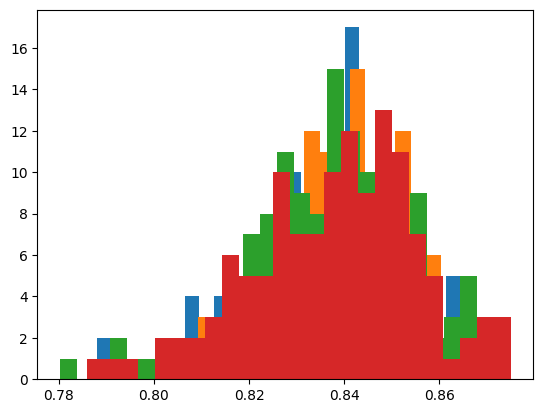

In [29]:
for n in range(len(net_params)):
    if len(net_params[n][1].shape)>0:
        _ = plt.hist(net_params[n][1], 25)

# Training Loop
---

In [31]:
@jit
def predict(args_in, X):
    """ Scans over time and return predictions. """
    # net_params, net_states = args_in
    _, net_states_hist = scan(hsnn_step, args_in, X, length=args.nb_steps)
    return net_states_hist
# vmap the forward of the model
v_predict = vmap(predict, in_axes=(None, 0))

def one_hot(x, n_class):
    return jnp.array(x[:, None] == jnp.arange(n_class), dtype=jnp.float32)

def loss(key, net_params, net_states, X, Y, epoch):
    """ Calculates CE loss after predictions. """

    # we might want to add noise in the forward pass --> memristor-aware-training
    # weight = [net_params[i][0] for i in range( len(net_params) )]
    # weight = cond(
    #     epoch >= noise_start_step, 
    #     lambda weight, key : add_noise(weight, key, noise_std),
    #     lambda weight, key : weight,
    #     weight, key
    # )
    # forward pass
    net_states_hist = v_predict( [net_params, net_states], X)
    out_v_mem = net_states_hist[-1][2]
    Yhat = decoder_vmax( out_v_mem )
    # compute the loss and correct examples
    num_correct = jnp.sum(jnp.equal(jnp.argmax(Yhat, 1), jnp.argmax(Y, 1)))
    loss_ce = -jnp.mean(jnp.sum( jnp.log(Yhat * Y + 1e-8), axis=-1, dtype=jnp.float32))
    # loss_fr = np.mean(target_fr - 10 * np.mean(out_v_mem)) ** 2
    ################# ----> Do I need the spiking frequency regularizer?
    loss_total = loss_ce #+ loss_fr * lambda_fr
    loss_values = [num_correct, 10 * np.mean(out_v_mem), loss_ce]
    return loss_total, loss_values

# testing the training function
args_ins = [net_params, net_states]
args_out = scan(hsnn_step, args_ins, x_train[0], length=args.nb_steps)
[net_params_hist, net_states_hist] = args_out

net_states_hist = v_predict( [net_params, net_states], x_train )
out_v_mem = net_states_hist[-1][2]

# decoder
Yhat = jax.nn.softmax( jnp.mean( out_v_mem, axis=1 ), axis=-1 )
Yhat_vmax = jax.nn.softmax( jnp.max( out_v_mem, axis=1 ), axis=-1 )
Yhat_cum = jnp.mean( jax.nn.softmax( out_v_mem, axis=-1 ), axis=1)
print( Yhat_cum.shape )

# loss
loss_total, loss_values = loss(key, net_params, net_states, x_train, one_hot(Y, 20), 0)

# values and gradients
value, grads = value_and_grad(loss, has_aux=True, argnums=(1))(key, net_params, net_states, x_train, one_hot(Y,20), 0)

(128, 20)


In [7]:
def train_mosaic(key, n_batch, n_epochs, args, 
                 lr, train_dl, test_dl, val_dl,
                 model, param_initializer, decoder, 
                 noise_start_step, noise_std, dataset_name):
    
    key, key_model = jax.random.split(key, 2)

    @jit
    def predict(args_in, X):
        """ Scans over time and return predictions. """
        _, net_states_hist = scan(model, args_in, X, length=args.nb_steps)
        return net_states_hist
    # vmap the forward of the model
    v_predict = vmap(predict, in_axes=(None, 0))

    def loss(key, net_params, net_states, X, Y, epoch):
        """ Calculates CE loss after predictions. """

        # we might want to add noise in the forward pass --> memristor-aware-training
        # weight = [net_params[i][0] for i in range( len(net_params) )]
        # weight = cond(
        #     epoch >= noise_start_step, 
        #     lambda weight, key : add_noise(weight, key, noise_std),
        #     lambda weight, key : weight,
        #     weight, key
        # )
        # forward pass
        net_states_hist = v_predict( [net_params, net_states], X)
        out_v_mem = net_states_hist[-1][2]
        Yhat = decoder( out_v_mem )
        # compute the loss and correct examples
        num_correct = jnp.sum(jnp.equal(jnp.argmax(Yhat, 1), jnp.argmax(Y, 1)))
        # cross entropy loss
        # loss_ce = -jnp.mean( jnp.log( jnp.sum( Yhat * Y, axis=-1, dtype=jnp.float32) + 1e-8 ) )
        loss_ce = -jnp.mean( jnp.sum(Y * jnp.log(Yhat), axis=-1) )
        # L2 norm
        loss_l2 = optimizers.l2_norm( net_params ) * args.l2_lambda
        # firing rate loss
        avg_spikes_neuron = jnp.mean( jnp.stack( [ jnp.mean( jnp.sum( net_states_hist[l][3], axis=1 ), axis=(0,-1) ) for l in range( len(net_params)-1 )] ) )
        loss_fr = args.freq_lambda * (args.target_fr - avg_spikes_neuron)**2
        ################# ----> Do I need the spiking frequency regularizer?
        loss_total = loss_ce + loss_l2 + loss_fr
        loss_values = [num_correct, loss_ce]
        return loss_total, loss_values
 
    @jit
    def update(key, epoch, net_states, X, Y, opt_state):
        train_params = get_params(opt_state)
        # forward pass with gradients
        value, grads = value_and_grad(loss, has_aux=True, argnums=(1))(key, train_params, net_states, X, Y, epoch)
        # possibly disable gradients on alpha and gradient clip
        for g in range( len( grads ) ):
            grads[g][0] = np.clip(grads[g][0], -args.grad_clip, args.grad_clip)
            grads[g][1] = np.clip(grads[g][1], -args.grad_clip, args.grad_clip)
        return grads, opt_state, value

    def one_hot(x, n_class):
        return np.array(x[:, None] == np.arange(n_class), dtype=np.float32)

    def total_correct(net_params, net_states, X, Y):
        net_states_hist = v_predict( [net_params, net_states], X)
        out_v_mem = net_states_hist[-1][2]
        Yhat = decoder( out_v_mem )
        acc = jnp.sum(jnp.equal(jnp.argmax(Yhat, 1), Y))
        return acc

    # LR decay
    if args.lr_decay_every < n_epochs:
        lr_decay = jnp.clip( args.lr_decay, 0, 1 )
        intervals = [i*args.lr_decay_every for i in range(int(n_epochs/args.lr_decay_every)-1)]
        lr_values = [lr*(lr_decay)**i for i in range(int(n_epochs/args.lr_decay_every))]
        pw_lr = optimizers.piecewise_constant(intervals, lr_values)
    else: pw_lr = optimizers.piecewise_constant([n_epochs], [lr, lr*jnp.clip( args.lr_decay, 0, 1 )])
    # define the optimizer
    opt_init, opt_update, get_params = optimizers.adam(step_size=pw_lr)
    # opt_init, opt_update, get_params = optimizers.sgd(step_size=pw_lr)
    # initialize the parameters (and states)
    net_params, net_states = param_initializer( key_model, args )
    opt_state = opt_init(net_params)

    # Training loop
    train_loss = []
    train_step = 0
    for epoch in range(n_epochs):
        t = time.time()
        acc = 0; count = 0
        for batch_idx, (x, y) in enumerate(train_dl):
            y = one_hot(y, args.n_out)
            key, _ = jax.random.split(key)
            grads, opt_state, (L, [tot_correct, _]) = update(key, epoch, net_states, x, y, opt_state)
            # possibly remove gradient from alpha
            if not args.train_alpha: 
                for g in range(len(grads)): grads[g][1] *= 0
            # weight update
            opt_state = opt_update(epoch, grads, opt_state)
            net_params = get_params(opt_state)
            # clip alpha between 0 and 1
            if args.train_alpha:
                for g in range(len(net_params)): net_params[g][1] = jnp.clip(net_params[g][1], 0, 1)
            # append stats
            train_loss.append(L)
            train_step += 1
            acc += tot_correct
            count += x.shape[0]
        
        # Training logs
        train_acc = 100*acc/count
        elapsed_time = time.time() - t
        print(f'Epoch: [{epoch+1}/{n_epochs}] - Loss: {L:.5f} - '
              f'Training acc: {train_acc:.2f} - t: {elapsed_time:.2f} sec')
        # if epoch % 50 == 0:
        #     # Save training state
        #     trained_params = optimizers.unpack_optimizer_state(opt_state)
        #     checkpoint_path = os.path.join('checkpoints', "checkpoint.pkl")
        #     with open(checkpoint_path, "wb") as file:
        #         pickle.dump(trained_params, file)

    # Testing Loop
    if dataset_name == 'shd':
        shd_test_loader = test_dl
        shd_val_loader = val_dl
    elif dataset_name == 'ssc':
        ssc_test_loader = test_dl
        ssc_val_loader = val_dl
    elif dataset_name == 'all':
        shd_test_loader, ssc_test_loader = test_dl

    # SHD
    acc = 0; val_acc_shd = 0; count = 0
    if dataset_name in ['shd', 'all']:
        for batch_idx, (x, y) in enumerate(shd_val_loader):
            count += x.shape[0]
            acc += total_correct(net_params, net_states, x, y)
        val_acc_shd = 100*acc/count
        print(f'SHD Validation Accuracy: {val_acc_shd:.2f}')

    acc = 0; test_acc_shd = 0; count = 0
    if dataset_name in ['shd', 'all']:
        for batch_idx, (x, y) in enumerate(shd_test_loader):
            count += x.shape[0]
            acc += total_correct(net_params, net_states, x, y)
        test_acc_shd = 100*acc/count
        print(f'SHD Test Accuracy: {test_acc_shd:.2f}')

    # SSC
    acc = 0 ; test_acc_ssc = 0
    if dataset_name in ['ssc', 'all']:
        for batch_idx, (x, y) in enumerate(ssc_test_loader):
            acc += total_correct(net_params, net_states, x, y)
        test_acc_ssc = 100*acc/((batch_idx+1)*n_batch)
        print(f'SSC Test Accuracy: {test_acc_ssc:.2f}')

    return train_loss, test_acc_shd, test_acc_ssc, val_acc_shd, net_params

In [33]:
args.train_alpha = True
args.hierarchy_tau = False
args.distrib_tau = True
# network architecture
args.n_layers = 3
args.n_hid = 128
# time constants
args.tau_mem = 0.1
args.tau_out = 0.1
# weight init
args.w_scale = 0.4
# LR and regularizers
args.lr = 0.01
args.lr_decay = 0.5
args.lr_decay_every = 20
args.l2_lambda = 1e-5
args.freq_lambda = 5e-5
n_epochs = 20

train_loss, test_acc_shd, test_acc_ssc, val_acc_shd, net_params_trained = train_mosaic(key = jax.random.PRNGKey(args.seed), n_batch=args.batch_size, n_epochs=n_epochs, args = args, lr = args.lr, 
                                                                train_dl = train_loader_custom_collate, test_dl = test_loader_custom_collate, val_dl=val_loader_custom_collate,
                                                                model=hsnn_step, param_initializer=params_initializer, decoder=decoder_sum, 
                                                                noise_start_step=10, noise_std=0.1, dataset_name='shd')

Epoch: [1/20] - Loss: 2.83378 - Training acc: 13.50 - t: 7.34 sec
Epoch: [2/20] - Loss: 2.38547 - Training acc: 23.57 - t: 5.68 sec
Epoch: [3/20] - Loss: 1.86842 - Training acc: 32.60 - t: 5.72 sec
Epoch: [4/20] - Loss: 1.78804 - Training acc: 38.98 - t: 5.72 sec
Epoch: [5/20] - Loss: 1.67384 - Training acc: 46.89 - t: 5.69 sec
Epoch: [6/20] - Loss: 1.53004 - Training acc: 49.40 - t: 5.67 sec
Epoch: [7/20] - Loss: 1.32630 - Training acc: 53.25 - t: 5.72 sec
Epoch: [8/20] - Loss: 1.16060 - Training acc: 57.99 - t: 5.67 sec
Epoch: [9/20] - Loss: 1.10792 - Training acc: 61.34 - t: 5.67 sec
Epoch: [10/20] - Loss: 1.00100 - Training acc: 64.18 - t: 5.70 sec
Epoch: [11/20] - Loss: 1.02370 - Training acc: 65.63 - t: 5.71 sec
Epoch: [12/20] - Loss: 0.96654 - Training acc: 67.72 - t: 5.70 sec
Epoch: [13/20] - Loss: 0.96369 - Training acc: 67.24 - t: 5.70 sec
Epoch: [14/20] - Loss: 1.07613 - Training acc: 68.50 - t: 5.90 sec
Epoch: [15/20] - Loss: 0.84258 - Training acc: 68.72 - t: 5.79 sec
Epoc

In [20]:
def predict(args_in, X):
    """ Scans over time and return predictions. """
    # net_params, net_states = args_in
    _, net_states_hist = scan(hsnn_step, args_in, X, length=args.nb_steps)
    return net_states_hist
# vmap the forward of the model
v_predict = vmap(predict, in_axes=(None, 0))

# initialize parameters
net_params, net_states = params_initializer( jax.random.PRNGKey(args.seed), args )
acc = 0; count =0
for x_test, Y_test in train_loader_custom_collate :
    net_states_hist = v_predict( [net_params_trained, net_states], x_test)
    out_v_mem = net_states_hist[-1][2]
    Yhat = decoder_sum( out_v_mem )
    count += x_test.shape[0]
    acc += jnp.sum( (jnp.argmax(Yhat, axis=-1) == Y_test).astype(int) )
acc /= count
print(f'Acc {acc*100}')

Acc 7.924585819244385


In [19]:
jnp.mean( jnp.stack( [ jnp.mean( jnp.sum( net_states_hist[l][3], axis=1 ), axis=(0,-1) ) for l in range( len(net_params_trained)-1 )] ) )

Array(22.247112, dtype=float32)

In [ ]:
jnp.sum( net_states_hist[1][2][100], axis=0 )

In [23]:
net_params_trained[2][1]

Array(0.3797781, dtype=float32)

In [104]:
### try and do a forward pass
# load data
x_train, Y = next(iter( train_loader_custom_collate ))
x_test, Y_test = next(iter( test_loader_custom_collate ))
print('Input shape: train '+ str(x_train.shape) + ' - test '+ str(x_test.shape) )

# initialize parameters
net_params, net_states = params_initializer( key, args )

net_states_hist = v_predict( [net_params_trained, net_states], x_test)
out_v_mem = net_states_hist[-1][2]
Yhat = decoder_sum( out_v_mem )

Input shape: train (128, 200, 256) - test (128, 200, 256)


In [101]:
j = 1
jnp.max(out_v_mem[j], axis=0), jnp.argmax( jnp.max(out_v_mem[j], axis=0), axis=0), Y_test[j]

(Array([ 4.431197 ,  3.4919863,  4.030807 ,  4.798508 ,  1.5315102,
         7.690341 ,  0.8310671,  7.405165 ,  4.16926  ,  6.630653 ,
         5.684929 ,  9.880762 ,  8.699758 ,  9.446497 ,  5.2380466,
         3.788078 ,  8.342206 ,  3.9432   , 11.005597 ,  4.43839  ],      dtype=float32),
 Array(18, dtype=int32),
 11)

In [100]:
(jnp.argmax(Yhat, axis=-1), Y_test), jnp.mean( (jnp.argmax(Yhat, axis=-1) == Y_test).astype(int) )

((Array([ 3, 18,  7,  0, 10, 16,  0,  4, 18, 18, 18, 14, 17,  8, 17, 16,  0,
          8, 14,  9, 12, 19, 16,  0,  8,  5,  4,  0, 11, 16,  6, 17,  0,  9,
          8,  8, 13, 17, 12, 10, 16,  8,  6,  0, 18,  8,  7, 12, 18,  7, 16,
          5, 18,  6, 11,  6, 14, 15, 11, 17,  5, 11, 10,  7, 14, 18, 11, 19,
         13,  5, 15, 11,  9,  0, 14, 18,  4, 15,  7, 12,  8, 17, 19, 17,  7,
          8, 19, 10, 10, 12,  7, 16, 13,  8,  7, 17, 19,  9,  8, 12, 18, 18,
          9,  9, 16, 13, 13, 18, 18, 10, 16,  0,  0,  4, 19, 13, 18,  3, 16,
          7, 12, 10, 12, 15,  4, 18, 13,  7], dtype=int32),
  array([10, 11,  7, 10,  3,  5,  0, 10, 18,  5, 16, 14, 12,  8,  0, 16, 10,
         16, 17, 13, 19,  9,  7,  4,  6,  9,  0,  0,  9,  9,  6,  2,  3, 12,
          8,  8,  7, 10, 12, 10, 14,  8,  6,  0, 11,  8,  7, 17,  5,  7, 13,
         11, 18,  6, 11,  6, 15, 17, 14,  0,  1, 18, 17, 13,  0, 18, 13,  5,
         14,  1, 10, 13, 14, 14, 10, 11,  4,  3,  7, 17,  8,  7, 14, 14,  7,
         16,  3,

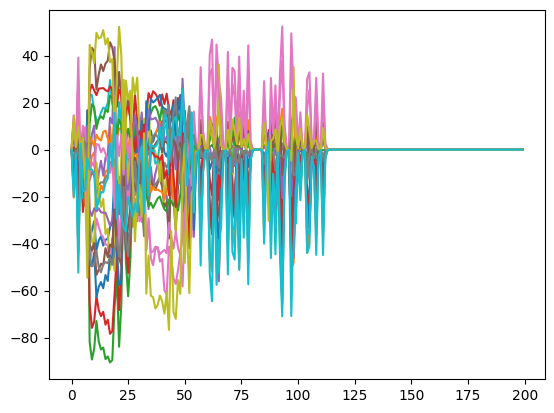

In [105]:
_ = plt.plot( out_v_mem[1] )

In [ ]:
i = 2
net_params, net_states = params_initializer( jax.random.PRNGKey(args.seed), args )
net_params_trained[i][0] - net_params[i][0]

In [26]:
args.train_alpha = True
args.hierarchy_tau = True
train_loss, test_acc_shd, test_acc_ssc, weight = train_mosaic(key = jax.random.PRNGKey(args.seed), n_batch=args.batch_size, n_epochs=50, args = args, 
                                                                lr = args.lr, lr_dropstep=1., 
                                                                train_dl = train_loader_custom_collate, test_dl = test_loader_custom_collate, 
                                                                model=hsnn_step, param_initializer=params_initializer, decoder=decoder_vmax, 
                                                                noise_start_step=10, noise_std=0.1,
                                                                target_fr=None, lambda_fr=None, dataset_name='shd')

Epoch: [0/50] - Loss: 1.76 - Training acc: 19.85 - t: 10.26 sec
Epoch: [1/50] - Loss: 1.10 - Training acc: 56.48 - t: 4.48 sec
Epoch: [2/50] - Loss: 0.77 - Training acc: 68.75 - t: 4.39 sec
Epoch: [3/50] - Loss: 0.69 - Training acc: 76.07 - t: 4.38 sec
Epoch: [4/50] - Loss: 0.72 - Training acc: 79.63 - t: 4.41 sec
Epoch: [5/50] - Loss: 0.57 - Training acc: 82.14 - t: 4.40 sec
Epoch: [6/50] - Loss: 0.54 - Training acc: 84.93 - t: 4.43 sec
Epoch: [7/50] - Loss: 0.34 - Training acc: 86.60 - t: 4.51 sec
Epoch: [8/50] - Loss: 0.38 - Training acc: 88.94 - t: 4.52 sec
Epoch: [9/50] - Loss: 0.32 - Training acc: 89.51 - t: 4.46 sec
Epoch: [10/50] - Loss: 0.34 - Training acc: 90.95 - t: 4.49 sec
Epoch: [11/50] - Loss: 0.24 - Training acc: 92.00 - t: 4.43 sec
Epoch: [12/50] - Loss: 0.27 - Training acc: 93.08 - t: 4.46 sec
Epoch: [13/50] - Loss: 0.19 - Training acc: 94.52 - t: 4.43 sec
Epoch: [14/50] - Loss: 0.19 - Training acc: 94.65 - t: 4.46 sec
Epoch: [15/50] - Loss: 0.17 - Training acc: 95.47